# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = './input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

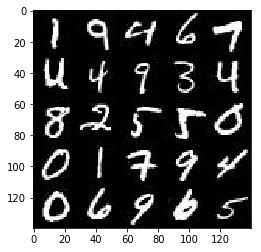

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

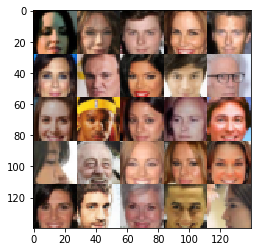

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(
        tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(
        tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
# Batch norm is not applied on the first layer.
# Batch norm is not applied on the last layer.
# Batch-normed layers don't use bias.
# We apply activation fcn manually on those layers.
# All hidden layers use Leaky ReLU activation fcn.
# If we don't specify initializer, the default choice
# is Xavier, but with Uniform random distribution.
# Batch normalization makes the choice of initialization
# less important, so it works roughly the same in general.

def discriminator(images, reuse=False, alpha=0.2, training=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean; if the weights should be reused
    :param alpha: Float; leak parameter for leaky ReLU
    :param training: Boolean; used in batch_normalization()
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        initializer = tf.contrib.layers.xavier_initializer(uniform=False)
        
        # Input layer is 28x28xout_channel_dim
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                                 activation=None, use_bias=True, kernel_initializer=initializer)
        conv1 = tf.maximum(alpha * conv1, conv1)  # Leaky ReLU
        # (14, 14, 64) now
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same',
                                 activation=None, use_bias=False, kernel_initializer=initializer)
        conv2 = tf.layers.batch_normalization(conv2, training=training)
        conv2 = tf.maximum(alpha * conv2, conv2)  # Leaky ReLU
        # (7, 7, 128) now
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same',
                                 activation=None, use_bias=False, kernel_initializer=initializer)
        conv3 = tf.layers.batch_normalization(conv3, training=training)
        conv3 = tf.maximum(alpha * conv3, conv3)  # Leaky ReLU
        # (4, 4, 256) now
        
        flat = tf.reshape(conv3, (-1, 4 * 4 * 256))  # -1 is for batch size (axis 0)
        logits = tf.layers.dense(flat, 1, activation=None,
                                 use_bias=True, kernel_initializer=initializer)
        out = tf.sigmoid(logits)  # probability of an example being '1', which represents "real data"
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
# Batch norm is not applied on the last layer.
# We don't need to use bias on batch-normed layers.
# We apply activation fcn manually on those layers.
# If we don't specify initializer, the default choice
# is Xavier, but with Uniform random distribution.
# Batch normalization makes the choice of initialization
# less important, so it works roughly the same in general.
# out_channel_dim is the number of color channels (1 or 3).

def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        initializer = tf.contrib.layers.xavier_initializer(uniform=False)
        
        # First, fully connected layer
        fc1 = tf.layers.dense(inputs=z, units=3*3*512, activation=None,
                              use_bias=False, kernel_initializer=initializer)
        fc1 = tf.reshape(fc1, (-1, 3, 3, 512))  # -1 is for batch size (axis 0)
        fc1 = tf.layers.batch_normalization(fc1, training=is_train)
        fc1 = tf.maximum(alpha * fc1, fc1)  # Leaky ReLU
        # (3, 3, 512) now
        
        conv2 = tf.layers.conv2d_transpose(fc1, 256, 5, strides=1, padding='valid',
                                           activation=None, use_bias=False, kernel_initializer=initializer)
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)  # Leaky ReLU
        # (7, 7, 256) now
        
        conv3 = tf.layers.conv2d_transpose(conv2, 128, 5, strides=2, padding='same',
                                           activation=None, use_bias=False, kernel_initializer=initializer)
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.maximum(alpha * conv3, conv3)  # Leaky ReLU
        # (14, 14, 128) now
        
        # Output layer, 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(conv3, out_channel_dim, 5, strides=2, padding='same',
                                           activation=None, use_bias=True, kernel_initializer=initializer)
        # (28, 28, out_channel_dim) now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=(tf.ones_like(d_logits_real) * (1. - smooth))))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
tf.reset_default_graph()
    
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    alpha = 0.2
    print_every = 10
    show_every = 100
    steps = 0
    
    num_images, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels, alpha=alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)      
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(epoch_count):            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Images for discriminator
                batch_images *= 2.0  # scale them to [-1, 1]
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={
                        input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    # After every print_every batches, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5337... Generator Loss: 3.4160
Epoch 1/2... Discriminator Loss: 0.4098... Generator Loss: 5.6987
Epoch 1/2... Discriminator Loss: 0.6376... Generator Loss: 7.1183
Epoch 1/2... Discriminator Loss: 0.4196... Generator Loss: 4.8624
Epoch 1/2... Discriminator Loss: 0.4622... Generator Loss: 2.7391
Epoch 1/2... Discriminator Loss: 0.9742... Generator Loss: 1.1711
Epoch 1/2... Discriminator Loss: 1.2444... Generator Loss: 9.1358
Epoch 1/2... Discriminator Loss: 2.2696... Generator Loss: 0.1931
Epoch 1/2... Discriminator Loss: 3.0208... Generator Loss: 0.0966
Epoch 1/2... Discriminator Loss: 0.6702... Generator Loss: 1.9961


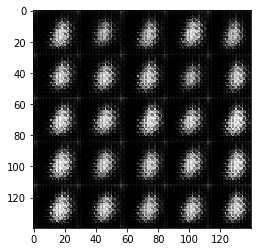

Epoch 1/2... Discriminator Loss: 0.4963... Generator Loss: 3.0283
Epoch 1/2... Discriminator Loss: 0.5673... Generator Loss: 2.3956
Epoch 1/2... Discriminator Loss: 0.4799... Generator Loss: 2.8715
Epoch 1/2... Discriminator Loss: 0.4115... Generator Loss: 3.6170
Epoch 1/2... Discriminator Loss: 0.3925... Generator Loss: 3.7386
Epoch 1/2... Discriminator Loss: 0.4115... Generator Loss: 3.4246
Epoch 1/2... Discriminator Loss: 0.4593... Generator Loss: 2.7560
Epoch 1/2... Discriminator Loss: 0.4307... Generator Loss: 2.9755
Epoch 1/2... Discriminator Loss: 0.4296... Generator Loss: 3.6610
Epoch 1/2... Discriminator Loss: 0.4453... Generator Loss: 3.0661


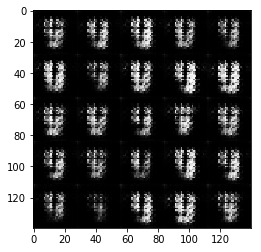

Epoch 1/2... Discriminator Loss: 0.3902... Generator Loss: 3.7360
Epoch 1/2... Discriminator Loss: 2.0526... Generator Loss: 8.4485
Epoch 1/2... Discriminator Loss: 0.5705... Generator Loss: 2.0732
Epoch 1/2... Discriminator Loss: 0.7708... Generator Loss: 3.5199
Epoch 1/2... Discriminator Loss: 0.5999... Generator Loss: 2.8687
Epoch 1/2... Discriminator Loss: 0.6575... Generator Loss: 3.7427
Epoch 1/2... Discriminator Loss: 0.4742... Generator Loss: 3.0397
Epoch 1/2... Discriminator Loss: 0.6807... Generator Loss: 1.6474
Epoch 1/2... Discriminator Loss: 0.4884... Generator Loss: 2.8252
Epoch 1/2... Discriminator Loss: 0.4929... Generator Loss: 2.8070


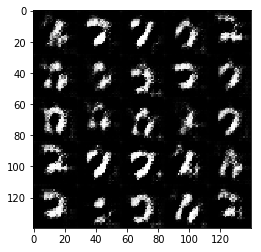

Epoch 1/2... Discriminator Loss: 0.6393... Generator Loss: 1.9120
Epoch 1/2... Discriminator Loss: 0.6559... Generator Loss: 2.0147
Epoch 1/2... Discriminator Loss: 0.5250... Generator Loss: 2.5342
Epoch 1/2... Discriminator Loss: 0.7734... Generator Loss: 4.2903
Epoch 1/2... Discriminator Loss: 1.0444... Generator Loss: 0.9467
Epoch 1/2... Discriminator Loss: 0.5322... Generator Loss: 2.5253
Epoch 1/2... Discriminator Loss: 0.5968... Generator Loss: 2.3940
Epoch 1/2... Discriminator Loss: 0.7879... Generator Loss: 1.7166
Epoch 1/2... Discriminator Loss: 0.6136... Generator Loss: 1.9214
Epoch 1/2... Discriminator Loss: 0.6583... Generator Loss: 2.1965


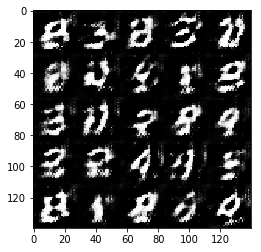

Epoch 1/2... Discriminator Loss: 1.1329... Generator Loss: 3.4177
Epoch 1/2... Discriminator Loss: 0.7856... Generator Loss: 1.3237
Epoch 1/2... Discriminator Loss: 0.7536... Generator Loss: 1.7825
Epoch 1/2... Discriminator Loss: 0.7923... Generator Loss: 1.3099
Epoch 1/2... Discriminator Loss: 0.6543... Generator Loss: 1.9766
Epoch 1/2... Discriminator Loss: 0.7813... Generator Loss: 2.4528
Epoch 2/2... Discriminator Loss: 1.1934... Generator Loss: 0.7590
Epoch 2/2... Discriminator Loss: 0.8880... Generator Loss: 3.1965
Epoch 2/2... Discriminator Loss: 0.7937... Generator Loss: 2.3229
Epoch 2/2... Discriminator Loss: 0.7000... Generator Loss: 1.9796


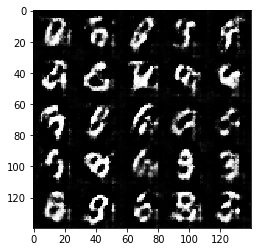

Epoch 2/2... Discriminator Loss: 0.8819... Generator Loss: 2.1852
Epoch 2/2... Discriminator Loss: 0.9531... Generator Loss: 1.7622
Epoch 2/2... Discriminator Loss: 0.8538... Generator Loss: 1.3051
Epoch 2/2... Discriminator Loss: 0.7509... Generator Loss: 1.8795
Epoch 2/2... Discriminator Loss: 0.9217... Generator Loss: 1.0265
Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 2.9035
Epoch 2/2... Discriminator Loss: 0.8061... Generator Loss: 1.5239
Epoch 2/2... Discriminator Loss: 0.8327... Generator Loss: 1.3366
Epoch 2/2... Discriminator Loss: 1.0564... Generator Loss: 0.8093
Epoch 2/2... Discriminator Loss: 0.8255... Generator Loss: 1.8403


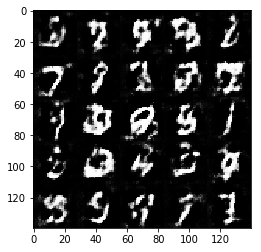

Epoch 2/2... Discriminator Loss: 0.8129... Generator Loss: 1.3842
Epoch 2/2... Discriminator Loss: 0.8382... Generator Loss: 1.6335
Epoch 2/2... Discriminator Loss: 0.9693... Generator Loss: 2.6960
Epoch 2/2... Discriminator Loss: 1.0147... Generator Loss: 0.8905
Epoch 2/2... Discriminator Loss: 1.0864... Generator Loss: 2.3226
Epoch 2/2... Discriminator Loss: 0.8539... Generator Loss: 1.3695
Epoch 2/2... Discriminator Loss: 0.9637... Generator Loss: 0.9509
Epoch 2/2... Discriminator Loss: 0.8773... Generator Loss: 1.6644
Epoch 2/2... Discriminator Loss: 1.0713... Generator Loss: 2.4037
Epoch 2/2... Discriminator Loss: 0.8212... Generator Loss: 1.3370


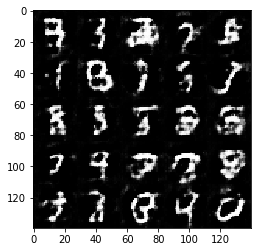

Epoch 2/2... Discriminator Loss: 0.7807... Generator Loss: 1.5636
Epoch 2/2... Discriminator Loss: 0.7852... Generator Loss: 1.8724
Epoch 2/2... Discriminator Loss: 1.0023... Generator Loss: 0.8870
Epoch 2/2... Discriminator Loss: 1.2715... Generator Loss: 0.6676
Epoch 2/2... Discriminator Loss: 0.9395... Generator Loss: 1.0361
Epoch 2/2... Discriminator Loss: 0.8684... Generator Loss: 1.3952
Epoch 2/2... Discriminator Loss: 0.8508... Generator Loss: 1.6708
Epoch 2/2... Discriminator Loss: 0.8746... Generator Loss: 1.2509
Epoch 2/2... Discriminator Loss: 0.9854... Generator Loss: 0.9135
Epoch 2/2... Discriminator Loss: 0.9862... Generator Loss: 0.9031


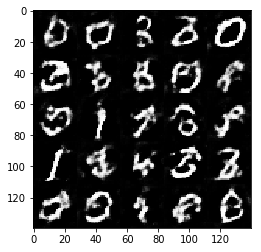

Epoch 2/2... Discriminator Loss: 0.8791... Generator Loss: 1.1423
Epoch 2/2... Discriminator Loss: 0.7731... Generator Loss: 1.6874
Epoch 2/2... Discriminator Loss: 0.9958... Generator Loss: 1.0356
Epoch 2/2... Discriminator Loss: 0.9575... Generator Loss: 1.1461
Epoch 2/2... Discriminator Loss: 0.9456... Generator Loss: 1.5464
Epoch 2/2... Discriminator Loss: 0.8857... Generator Loss: 1.6641
Epoch 2/2... Discriminator Loss: 0.8803... Generator Loss: 1.6161
Epoch 2/2... Discriminator Loss: 0.8881... Generator Loss: 1.3516
Epoch 2/2... Discriminator Loss: 1.0002... Generator Loss: 1.8647
Epoch 2/2... Discriminator Loss: 0.9488... Generator Loss: 2.1734


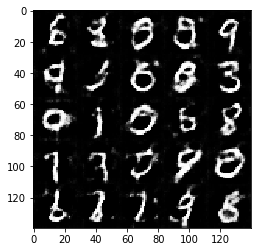

Epoch 2/2... Discriminator Loss: 1.0149... Generator Loss: 0.8303
Epoch 2/2... Discriminator Loss: 1.1158... Generator Loss: 0.7793
Epoch 2/2... Discriminator Loss: 1.0570... Generator Loss: 1.7703


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 1.0673
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 0.6701... Generator Loss: 1.7226
Epoch 1/1... Discriminator Loss: 0.5193... Generator Loss: 4.8611
Epoch 1/1... Discriminator Loss: 0.4521... Generator Loss: 9.3622
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 11.1532
Epoch 1/1... Discriminator Loss: 0.6338... Generator Loss: 1.9527
Epoch 1/1... Discriminator Loss: 0.8181... Generator Loss: 1.2522
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 9.8308
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.6726


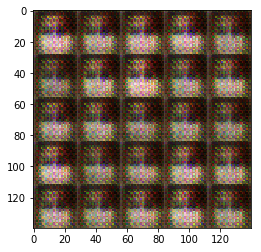

Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 2.8014
Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 2.2787
Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 1.9142
Epoch 1/1... Discriminator Loss: 0.7429... Generator Loss: 2.0246
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 1.5281
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 4.7049
Epoch 1/1... Discriminator Loss: 0.6661... Generator Loss: 1.7216
Epoch 1/1... Discriminator Loss: 0.7404... Generator Loss: 1.3802
Epoch 1/1... Discriminator Loss: 0.6343... Generator Loss: 1.9145
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 1.4730


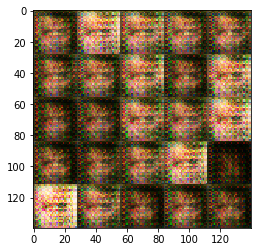

Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 2.3527
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 1.3036
Epoch 1/1... Discriminator Loss: 0.7150... Generator Loss: 2.1523
Epoch 1/1... Discriminator Loss: 0.5779... Generator Loss: 3.9227
Epoch 1/1... Discriminator Loss: 0.5319... Generator Loss: 2.3649
Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 1.1564
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 2.9440
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 2.1509
Epoch 1/1... Discriminator Loss: 0.7851... Generator Loss: 1.4934


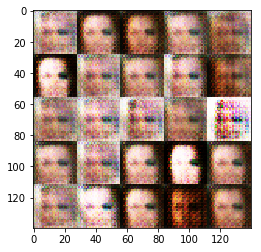

Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 1.9542
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 3.1532
Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 1.7338
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 1.0973
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 1.2861
Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 1.2140
Epoch 1/1... Discriminator Loss: 0.7798... Generator Loss: 1.9870
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 1.3204


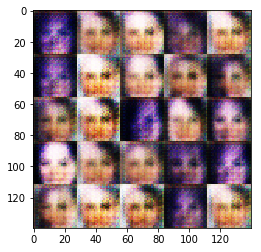

Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 1.5607
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 2.3156
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 1.5023
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 1.2660
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 1.8144
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 1.5709
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 1.1223
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 1.4940


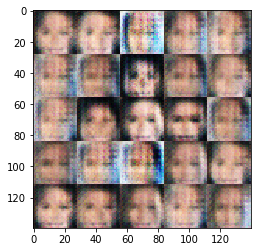

Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.1817
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 1.8313
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 1.7381
Epoch 1/1... Discriminator Loss: 0.9559... Generator Loss: 1.1755
Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 1.5141
Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 1.7246
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 2.0904
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 1.2022


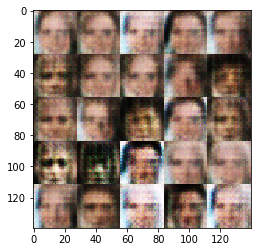

Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 0.7830... Generator Loss: 1.7101
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 1.6194
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 1.6081
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 1.1823
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.0068
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 1.1600
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 1.5082
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 2.0934
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.1768


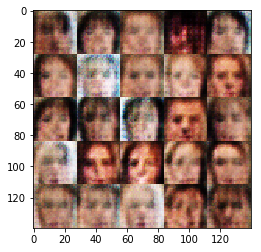

Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 1.4178
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 1.5816
Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 1.3935
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.0406
Epoch 1/1... Discriminator Loss: 0.9106... Generator Loss: 1.5404
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.9424
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 1.0314
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 1.2308
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 1.2095


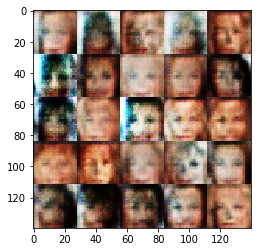

Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 2.5142
Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 1.0859
Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 1.3800
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 1.2403
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 1.4878
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 1.2789
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 1.5791
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 1.0551
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 0.9581


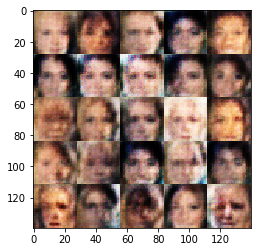

Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 1.0983
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 1.3730
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 1.1914
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 1.7357
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 2.0834
Epoch 1/1... Discriminator Loss: 0.8374... Generator Loss: 1.5765
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 1.1238
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 1.0320


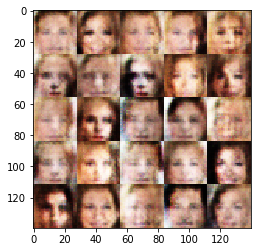

Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 1.0921
Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 1.4038
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 1.1057
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 2.5234
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 1.9337
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 0.9185


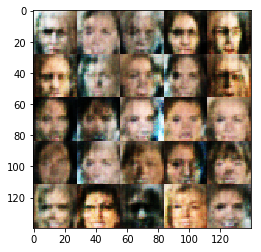

Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 1.1576
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 1.1215
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 1.9882
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 2.7075
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 1.8563
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 1.0025
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 1.0606


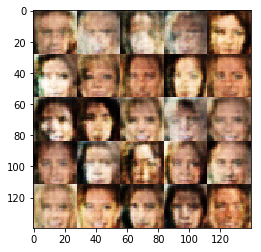

Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.2423
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 1.8895
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.6505
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 1.4325
Epoch 1/1... Discriminator Loss: 0.8982... Generator Loss: 2.0038


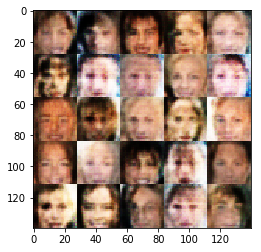

Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 2.5660
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 1.0999
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 1.1964
Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 1.4317
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.4606
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 1.3017
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.6240


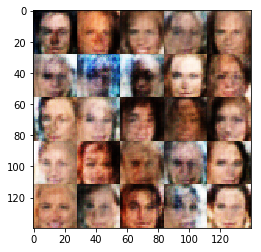

Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 1.4548
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.4922
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 1.3743
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 1.4585
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 1.8057
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 1.2378
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 1.0491
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 2.3740
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 2.2641


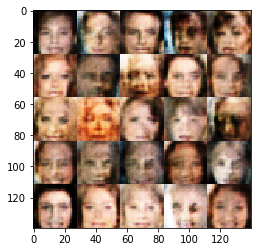

Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 1.6235
Epoch 1/1... Discriminator Loss: 0.6016... Generator Loss: 2.1239
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 1.0294
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 2.1305
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 1.0467
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 1.0712


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.